# Model Definition & Training & Evaluation Notebook

In this notebook, i'll document the entire process of model definition, training and evaluation

We import the data into a pandas dataframe

In [84]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_0b8917382c9d414ca2a51a83a0262bbd = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='U5TzTCGqnkwBtVgDzW5AafWuy6nLCgYLuwRi9HmRLOUh',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_0b8917382c9d414ca2a51a83a0262bbd.get_object(Bucket='loadingdataandviewingdatapandasan-donotdelete-pr-78pi1hg6bcwa5p',Key='creditcard.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)

The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns) and test it on the original testing set.

In [85]:
import numpy as np # linear algebra
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df_data_1['Class'].value_counts()[0]/len(df_data_1) * 100,2), '% of the dataset')
print('Frauds', round(df_data_1['Class'].value_counts()[1]/len(df_data_1) * 100,2), '% of the dataset')

X = df_data_1.drop('Class', axis=1)
y = df_data_1['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In this phase of the project we will implment "Random Under Sampling" which basically 
consists of removing data in order to have a more balanced dataset and thus avoiding
our models to overfitting.

In [86]:
df_data_1 = df_data_1.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df_data_1.loc[df_data_1['Class'] == 1]
non_fraud_df = df_data_1.loc[df_data_1['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

Added PCA, T-SNE and TruncatedSVD as additional features.

We'll use logistic regression, KNN and decision tree and evaluate the model performance

In [88]:
import warnings
warnings.filterwarnings("ignore")

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)

Start with logistic regression

In [89]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

# Overfitting Case
from sklearn.model_selection import cross_val_score

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.53%


In [90]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)

yhat = LR_model.predict(X_test)

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

LR_yhat = LR_model.predict(X_test)
LR_yhat_prob = LR_model.predict_proba(X_test)
print("Logistic Regression Jaccard index: %.2f" % jaccard_similarity_score(y_test, LR_yhat))
print("Logistic Regression F1-score: %.2f" % f1_score(y_test, LR_yhat, average='weighted') )
print("Logistic Regression LogLoss: %.2f" % log_loss(y_test, LR_yhat_prob))

Logistic Regression Jaccard index: 0.93
Logistic Regression F1-score: 0.93
Logistic Regression LogLoss: 0.19


We move on to KNN

In [91]:
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

Knears Neighbors Cross Validation Score 63.91%


In [92]:
# Modeling
from sklearn.neighbors import KNeighborsClassifier
k = 8
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)


# just for sanity chaeck
yhat = kNN_model.predict(X_test)


knn_yhat = kNN_model.predict(X_test)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted') )

KNN Jaccard index: 0.63
KNN F1-score: 0.63


We try to obtain the best K from the following

In [93]:
# Best k
Ks=15
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.63959391, 0.61928934, 0.66497462, 0.64467005, 0.64467005,
       0.64467005, 0.63959391, 0.63451777, 0.64467005, 0.60406091,
       0.64467005, 0.61928934, 0.63451777, 0.64974619])

# Attempt to do some Feature Engineering by filtering - just a simple thought

Just a thought maybe we removing some columns of Vs. Maybe our results will improve. I'll iterate till the results improve. We try dropping columns V13,14,22,23,25,26 (selected randomly).


In [94]:
drop_list = ['V26','V25','V23','V22','V14','V13']
X_new_attempt1 = X.drop(drop_list,axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_new_attempt1, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Logistic Regression

In [95]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

# Overfitting Case
from sklearn.model_selection import cross_val_score

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)

yhat = LR_model.predict(X_test)

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

LR_yhat = LR_model.predict(X_test)
LR_yhat_prob = LR_model.predict_proba(X_test)
print("Logistic Regression Jaccard index: %.2f" % jaccard_similarity_score(y_test, LR_yhat))
print("Logistic Regression F1-score: %.2f" % f1_score(y_test, LR_yhat, average='weighted') )
print("Logistic Regression LogLoss: %.2f" % log_loss(y_test, LR_yhat_prob))

Logistic Regression Cross Validation Score:  94.28%
Logistic Regression Jaccard index: 0.92
Logistic Regression F1-score: 0.92
Logistic Regression LogLoss: 0.22


The performance of the LR model decrease!

In [96]:
# Modeling
from sklearn.neighbors import KNeighborsClassifier
k = 8
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)


# just for sanity chaeck
yhat = kNN_model.predict(X_test)


knn_yhat = kNN_model.predict(X_test)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted') )

KNN Jaccard index: 0.63
KNN F1-score: 0.63


The performance of the KNN model decrease!

# Attempt (number 2) to do some Feature Engineering by filtering - just a simple thought

I'm have performed a few iterations and noticed that by dropping the Time and Amount columns. The model performance improves by as much as 0.2 for KNN

In [97]:
drop_list = ['V26','V25','V23','V22','V14','V13','Time','Amount']
X_new_attempt2 = X.drop(drop_list,axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_new_attempt2, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Logistic Regression

In [98]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

# Overfitting Case
from sklearn.model_selection import cross_val_score

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)

yhat = LR_model.predict(X_test)

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

LR_yhat = LR_model.predict(X_test)
LR_yhat_prob = LR_model.predict_proba(X_test)
print("Logistic Regression Jaccard index: %.2f" % jaccard_similarity_score(y_test, LR_yhat))
print("Logistic Regression F1-score: %.2f" % f1_score(y_test, LR_yhat, average='weighted') )
print("Logistic Regression LogLoss: %.2f" % log_loss(y_test, LR_yhat_prob))

Logistic Regression Cross Validation Score:  94.02%
Logistic Regression Jaccard index: 0.91
Logistic Regression F1-score: 0.91
Logistic Regression LogLoss: 0.23


K-Nearest Neighbor

In [99]:
# Modeling
from sklearn.neighbors import KNeighborsClassifier
k = 8
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)


# just for sanity chaeck
yhat = kNN_model.predict(X_test)


knn_yhat = kNN_model.predict(X_test)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(y_test, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(y_test, knn_yhat, average='weighted') )

KNN Jaccard index: 0.92
KNN F1-score: 0.92


The Jaccard index and F1-score for KNN algorithm increased from 0.7 to 0.93 but for Logistic Regression the Jaccard index, F1-score and LogLoss is actually worst than the original score by 0.01 from 0.92 to 0.91 and 0.22 to 0.23 for LogLoss.

Attempt to visualize the results, we perform dimensionality reduction using PCA for both the attempts

In [101]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# PCA Implementation
X_new_attempt1_pca = PCA(n_components=2, random_state=42).fit_transform(X_new_attempt1.values)
X_new_attempt2_pca = PCA(n_components=2, random_state=42).fit_transform(X_new_attempt2.values)

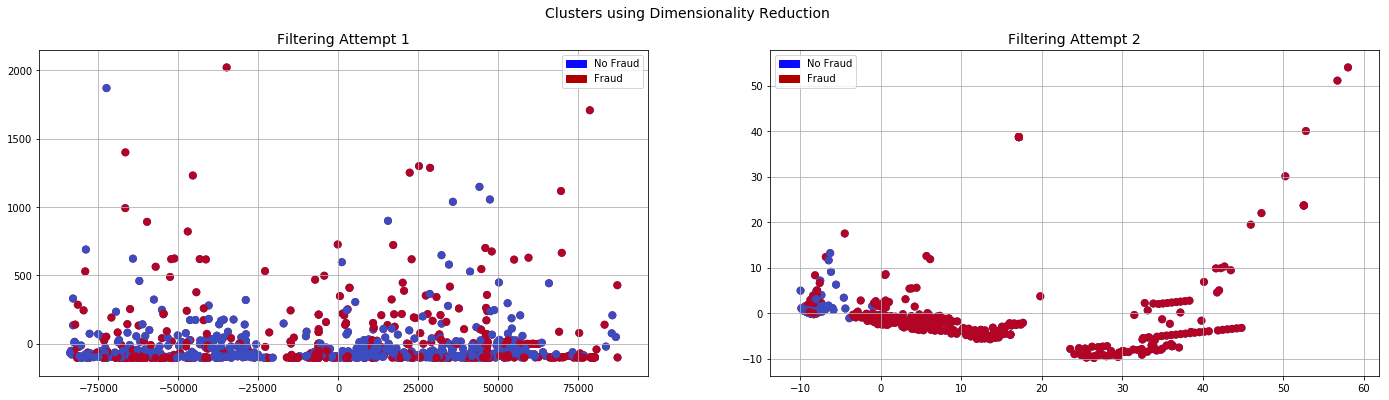

In [110]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6))

f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# PCA scatter plot
ax1.scatter(X_new_attempt1_pca[:,0], X_new_attempt1_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_new_attempt1_pca[:,0], X_new_attempt1_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('Filtering Attempt 1', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_new_attempt2_pca[:,0], X_new_attempt2_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_new_attempt2_pca[:,0], X_new_attempt2_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('Filtering Attempt 2', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

plt.show()

From the scatterplot, we can see that there exists a clear boundary for the second attempt and not for the first. No wonder the KNN algorithm is able to perform better!